In [1]:
import pandas as pd
# plots
import matplotlib.pyplot as plt
from matplotlib import dates
import plotly.express as px
# Establecer el estilo de la gráfica
plt.style.use('seaborn')
# models
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/tmp/ipykernel_38172/208948096.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### 1. Leer datos

In [2]:
df = pd.read_csv('../in/preprocess/df_time_monthly', parse_dates=True)
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.tz_localize(None)
df.set_index('date', inplace=True)
df.index.freq = 'M'
df.shape
df.head()

,cost,holidays_cont,month,year,days_in_month,is_year_start,is_year_end
date,,,,,,,
2019-09-30,1440500,0,9,2019,30,False,0
2019-10-31,1943400,1,10,2019,31,False,0
2019-11-30,1437850,2,11,2019,30,False,0
2019-12-31,1298200,1,12,2019,31,False,1
2020-01-31,4037250,2,1,2020,31,False,0


### 2.ARIMA 'Promedio Móvil Integrado AutoRegresivo'
Cualquier serie de tiempo 'no estacional' que muestre patrones y no sea un ruido blanco aleatorio se puede modelar con modelos ARIMA.
Si una serie temporal tiene patrones estacionales, debe agregar términos estacionales y se convierte en SARIMA, abreviatura de 'ARIMA estacional'.

### 2.1 Realizar una autocorrelación simple y parcial
para analizar la correlación entre la serie de tiempo y sus rezagos.
En el punto 2.1, elegimos un valor de lags=20 para incluir suficiente información pasada en el modelo VAR, lo que puede mejorar su capacidad para hacer pronósticos precisos. Tener en cuenta que no puede ser mayor al 50 % del tamaño de la muestra. Sin embargo, la elección del valor de lags puede variar dependiendo del conjunto de datos y del contexto del problema en cuestión.

Una forma común de seleccionar el valor adecuado de lags es mediante la técnica de "lag length selection" o "selección de longitud de retardo", que implica probar diferentes valores de lags y seleccionar aquel que proporcione el mejor desempeño del modelo en términos de criterios de información como el AIC (Akaike Information Criterion) o el BIC (Bayesian Information Criterion).

El gráfico ACF muestra la autocorrelación de la serie de tiempo con respecto a sus valores anteriores en diferentes retrasos (lags). Cada punto en el gráfico representa el coeficiente de correlación entre los valores de la serie de tiempo en el tiempo actual y el tiempo en el que se está calculando el retraso. Un valor cercano a 1 indica una fuerte autocorrelación positiva, mientras que un valor cercano a -1 indica una fuerte autocorrelación negativa.

El gráfico PACF muestra la correlación parcial entre dos puntos en la serie de tiempo, teniendo en cuenta los efectos de los valores intermedios. Es decir, muestra la correlación directa entre dos puntos, después de eliminar la influencia de los valores intermedios

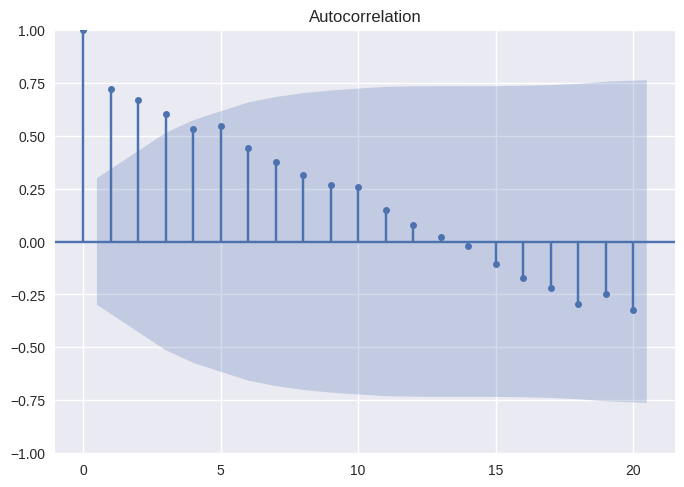

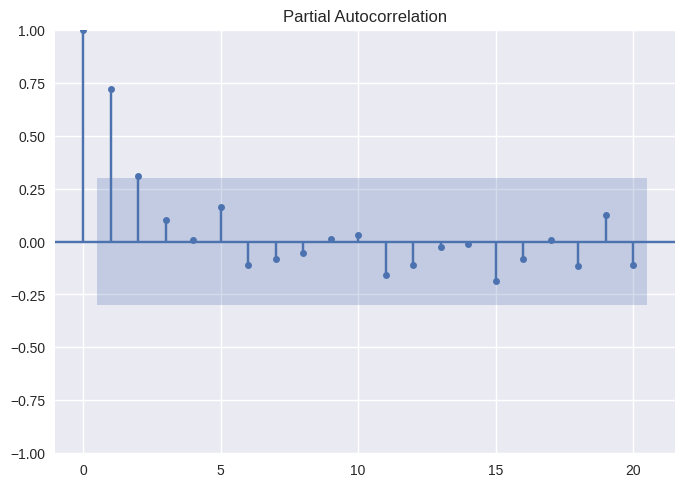

In [3]:
plot_acf(df['cost'], lags=20)
plt.show()

plot_pacf(df['cost'], lags=20)
plt.show()

1 ACF: La gráfica de ACF muestra que hay una correlación significativa entre el costo en un momento dado y los costos en los períodos anteriores. La correlación es alta para los primeros 2-3 lags y luego disminuye gradualmente a medida que aumenta el lag. Esto sugiere que los datos pueden tener una tendencia y/o una estacionalidad.

2 PACF: La gráfica de PACF muestra una fuerte correlación en el primer lag y luego una disminución gradual en la correlación a medida que aumenta el lag. Esto sugiere que hay una tendencia lineal en los datos.

En general, estas gráficas sugieren que tus datos pueden tener una estructura de serie de tiempo con una tendencia y/o una estacionalidad. Sería útil explorar más a fondo estas características de tus datos para modelarlos y predecir futuros valores

### 2.1.2 Cómo encontrar el orden del término AR (p)
El siguiente paso es identificar si el modelo necesita algún término AR. Puede averiguar el número necesario de términos AR inspeccionando el gráfico de autocorrelación parcial (PACF).
Puede observar que el PACF lag 1 es bastante significativo ya que está muy por encima de la línea de significación. El retraso 2 también resulta ser significativo, logrando cruzar ligeramente el límite de significación (región azul). Pero voy a ser conservador y tentativamente fijar la **p como 1**.



### 2.1.3 Cómo encontrar el orden del término MA (q)
Al igual que observamos el gráfico PACF para el número de términos AR, puede consultar el gráfico ACF para el número de términos MA. Un término MA es técnicamente el error del pronóstico retrasado. En el caso anterior de **q =2 a 3** lags

***encontrar orden de diferenciación***

In [4]:
kpss_diffs = ndiffs(df['cost'], alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(df['cost'], alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)
n_diffs

1

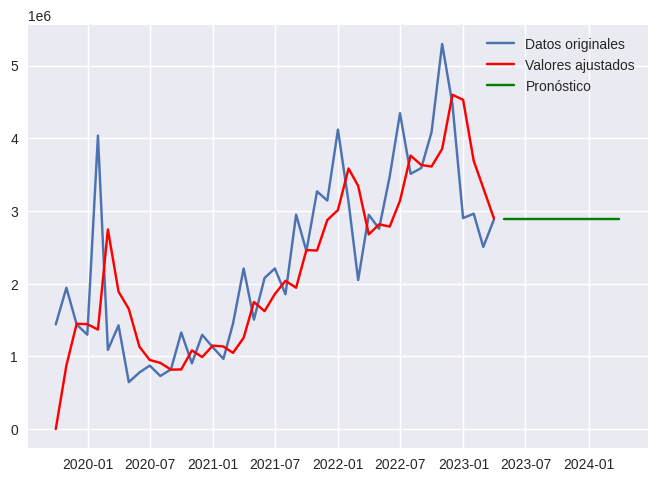

                               SARIMAX Results                                
Dep. Variable:                   cost   No. Observations:                   43
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -631.490
Date:                Tue, 09 May 2023   AIC                           1266.980
Time:                        15:02:31   BIC                           1270.455
Sample:                    09-30-2019   HQIC                          1268.253
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4843      0.097     -4.978      0.000      -0.675      -0.294
sigma2      5.166e+11   2.26e-14   2.29e+25      0.000    5.17e+11    5.17e+11
Ljung-Box (L1) (Q):                   0.02   Jarque-

In [5]:
model_order = (0,1,1) # reemplazar con los valores obtenidos en el punto 2.1.2 y 2.1.3 p, d q

# ajustar el modelo
model = ARIMA(df['cost'], order=model_order)
model_fit = model.fit()

# predecir valores futuros
forecast = model_fit.forecast(steps=12)

# graficar resultados
plt.plot(df['cost'])
plt.plot(model_fit.fittedvalues, color='red')
plt.plot(forecast, color='green')
plt.legend(['Datos originales', 'Valores ajustados', 'Pronóstico'])
plt.show()
print(model_fit.summary())

### 2.1.5 Cómo hacer Auto Arima Forecast en Python

In [6]:

import pmdarima as pm

model = pm.auto_arima(df['cost'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1269.939, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1273.736, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1269.527, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1268.397, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1271.810, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1272.828, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1266.980, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1268.760, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1271.624, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1267.689, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1273.379, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.298 seconds
                               SARIMAX Results                                
Dep. Variable:

### 3 sarimax

Cómo construir automáticamente el modelo SARIMA en python

In [4]:
#handle error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pmdarima.metrics import smape
# handle time
import locale
locale.setlocale(locale.LC_MONETARY, 'es_CO.UTF-8')
def metrict_error(y_true, y_pred):
    print('------ Métricas dependientes de la escala  --------')
    MAE = mean_absolute_error(y_true, y_pred)
    print('Error MAE    : ',  locale.currency(MAE, grouping=True))
    print('Error MSE    : ',mean_squared_error(y_true, y_pred))
    RMSE = mean_squared_error(y_true, y_pred, squared=False)
    print('Error RMSE   : ', locale.currency(RMSE, grouping=True))

    print('------ Métricas de porcentaje de error  --------')
    print('Error MAPE    : ',round(mean_absolute_percentage_error(y_true, y_pred) *100, 1), '%')
    print(f"SMAPE        : {round(smape(y_true, y_pred),2)}")


def train_test_time_series(ts):
    # Train Test Split Index
    train_size = 0.8
    split_idx = round(len(ts)* train_size)
    split_idx

    # Split
    train = ts.iloc[:split_idx]
    test = ts.iloc[split_idx:]

    # Visualize split
    # fig,ax= plt.subplots(figsize=(12,8))
    # kws = dict(marker='o')
    # plt.plot(train, label='Train', **kws)
    # plt.plot(test, label='Test', **kws)
    # ax.legend(bbox_to_anchor=[1,1]);
    return train, test
def plot_predict(train, test, forecast):
    train_plot = train
    train_plot['type'] = 'train'
    test_plot = test
    test_plot['type'] = 'test'
    forecast_plot = forecast
    forecast_plot['type'] = 'predict'
    forecast_plot = pd.concat([test_plot, train_plot, forecast_plot ],ignore_index=True)
    forecast_plot
    fig = px.line(forecast_plot, x='date', y="value", color="type",hover_data={"date": "|%B %d, %Y"}, title='Resultados de la predicción')
    fig.show()
    return forecast_plot

def precict_transform(model, train, test, y_col, period_test, is_diff=False, exogen_labels=[]):
    end = len(train) + len(test)
    exogx = train[exogen_labels]
    exogx_test = test[exogen_labels]
    has_exogen = bool(len(exogx) and len(exogx_test))

    if has_exogen:
        print('Aplica variables exógenas')
        forecast, conf_int = model.predict(n_periods=period_test, exogenous=exogx_test, return_conf_int=True)
    else:
        forecast, conf_int = model.predict(n_periods=period_test, return_conf_int=True)

    index_of_fc = pd.date_range(test.index[0], periods = period_test, freq='M')

    if is_diff:
        df_auto_pred = pd.DataFrame(forecast, columns=['value'])
        last_original_train = train.iloc[-1][y_col]# último dato antes diferenciar
        df_forescast = last_original_train + df_auto_pred.cumsum()
        df_forescast = df_forescast.set_index(index_of_fc)
        plot_predi = pd.DataFrame(data= {'value': df_forescast['value'], 'date': df_forescast.index})
        # d = {'lower': lower_series, 'upper': upper_series, 'pred':df_forescast[['value']]}
        # pred_df = pd.DataFrame(data=d)
    else:
        # make series for plotting purpose
        fitted_series = pd.Series(forecast, index=index_of_fc)
        lower_series = pd.Series(conf_int[:, 0], index=index_of_fc)
        upper_series = pd.Series(conf_int[:, 1], index=index_of_fc)
        d = {'lower': lower_series, 'upper': upper_series, 'pred':forecast}
        pred_df = pd.DataFrame(data=d)
        plot_predi = pd.DataFrame(data= {'value': pred_df['pred'], 'date': pred_df.index})




    plot_train = pd.DataFrame(data= {'value': train[y_col], 'date': train.index})
    plot_test = pd.DataFrame(data= {'value': test[y_col], 'date': test.index})

    metrict_error( test[y_col], plot_predi['value'] )
    forecast_plot = plot_predict(plot_train, plot_test, plot_predi)
    return forecast_plot
def precict_transform_2(model, train, test, y_col, var_exoge):
    end = len(train) + len(test)
    exogenus = test[var_exoge]
    forecast = model.predict(start=len(train), end=end-1, exog=exogenus)
    index_of_fc = pd.date_range(test.index[0], periods = len(forecast), freq='M')
    print('LEN index_of_fc:', len(index_of_fc))
    print('LEN forecast:', len(forecast))

        # make series for plotting purpose
    fitted_series = pd.Series(forecast, index=index_of_fc)
    # lower_series = pd.Series(conf_int[:, 0], index=index_of_fc)
    # upper_series = pd.Series(conf_int[:, 1], index=index_of_fc)

    d = {'pred':forecast}
    pred_df = pd.DataFrame(data=d)
    plot_train = pd.DataFrame(data= {'value': train[y_col], 'date': train.index})
    plot_test = pd.DataFrame(data= {'value': test[y_col], 'date': test.index})
    plot_predi = pd.DataFrame(data= {'value': pred_df['pred'], 'date': pred_df.index})
    print('--- ------- -------- -------------')
    print('TEST: ', test[y_col].shape)
    print('PRED: ', pred_df['pred'].shape)
    metrict_error( test[y_col], pred_df['pred'] )
    # print('Error MSE    : ',mean_squared_error(test[y_col],pred_df['pred']))
    # print('Error MAE   : ',mean_absolute_error(test[y_col],pred_df['pred']))
    forecast_plot = plot_predict(plot_train, plot_test, plot_predi)
    return forecast_plot

In [5]:
train, test = train_test_time_series(df)

In [37]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train['cost'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=613.902, Time=0.08 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=644.062, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=626.666, Time=0.05 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=615.872, Time=0.07 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(1,2,1)(1,1,1)[12]             : AIC=615.489, Time=0.21 sec
 ARIMA(1,2,1)(0,1,2)[12]             : AIC=615.411, Time=0.13 sec
 ARIMA(1,2,1)(1,1,0)[12]             : AIC=614.238, Time=0.07 sec
 ARIMA(1,2,1)(1,1,2)[12]             : AIC=617.397, Time=0.28 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=626.781, Time=0.04 sec
 ARIMA(2,2,1)(0,1,1)[12]             : AIC=614.853, Time=0.07 sec
 ARIMA(1,2,2)(0,1,1)[12]             : AIC=613.345, Time=0.08 sec
 ARIMA(1,2,2)(0,1,0)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(1,2,2)(1,1,1)[12]             : AIC=614.920, Time=0.15 sec
 ARIMA(1,2,2)(0,1,2)[12]             : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   34
Model:             SARIMAX(0, 2, 2)x(0, 1, [1], 12)   Log Likelihood                -301.706
Date:                              Fri, 05 May 2023   AIC                            611.413
Time:                                      08:30:28   BIC                            615.396
Sample:                                  09-30-2019   HQIC                           612.190
                                       - 06-30-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5194      0.399     -3.807      0.000      -2.302      -0.737
ma.L2          0.5383      0.284      1.894      0.058      -0.019       1.096
ma.S.L12      -0.6972      0.544     -1.282      0.200      -1.763       0.369
sigma2      8.236e+11   3.35e-13   2.46e+24      0.000    8.24e+11    8.24e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.40
Prob(Q):                              0.99   Prob(JB):                         0.50
Heteroskedasticity (H):               0.94   Skew:                            -0.60
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.83e+40. Standard errors may be unstable.
"""

In [10]:
# SARIMAX(0, 2, 2)x(0, 1, [1], 12)
mod = sm.tsa.statespace.SARIMAX(train['cost'], exog=train['days_in_month'], order=(1,1,0), seasonal_order=(0,1,0,12)).fit()
forecast_plot = precict_transform_2(mod, train, test, 'cost', 'days_in_month')


/home/bitsamericas/Documents/5-cursos/11-Platzi/platzi-curso-Machine-Learning-con-Scikit-Learn/entorno/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30343D+00    |proj g|=  1.94406D+00

At iterate    5    f=  9.07846D+00    |proj g|=  8.61644D-03

At iterate   10    f=  9.07826D+00    |proj g|=  8.57371D-02

At iterate   15    f=  9.07522D+00    |proj g|=  6.21550D-02

At iterate   20    f=  9.07498D+00    |proj g|=  3.33154D-03

At iterate   25    f=  9.07494D+00    |proj g|=  9.33424D-02

At iterate   30    f=  9.07392D+00    |proj g|=  1.49571D-01

At iterate   35    f=  9.07249D+00    |proj g|=  3.43422D-01

At iterate   40    f=  9.06990D+00    |proj g|=  2.92811D-02

At iterate   45    f=  9.06965D+00    |proj g|=  7.40801D-03

At iterate   50    f=  9.06958D+00    |proj g|=  2.23373D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/bitsamericas/Documents/5-cursos/11-Platzi/platzi-curso-Machine-Learning-con-Scikit-Learn/entorno/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [20]:

# borrar
mod1 = sm.tsa.statespace.SARIMAX(train['cost'], exog=train['days_in_month'], order=(1,1,0), seasonal_order=(0,1,0,12),disp=False).fit()
lenend = len(train) + len(test) -1
print('len(train) = ',len(train))
print('len(test)  = ',len(test))
print('final      =', lenend)
print('exogenus', test['days_in_month'].values)
my_predict = mod1.predict(start=len(train), end=lenend, exog=test['days_in_month'])
# print(my_predict)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10046D+01    |proj g|=  1.19902D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   3.944D-08   9.478D+00
  F =   9.4783116585647846     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
len(train) =  34
len(test)  =  9
final      = 42
exogenus [31 31 30 31 30 31 31 28 31]


/home/bitsamericas/Documents/2-proyectos/time-series-expense-control/myenv-py3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['disp']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
 This problem is unconstrained.
/home/bitsamericas/Documents/2-proyectos/time-series-expense-control/myenv-py3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['disp']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [21]:
print(my_predict)

2022-07-31    4.003173e+06
2022-08-31    5.098040e+06
2022-09-30    4.597665e+06
2022-10-31    5.417946e+06
2022-11-30    5.291909e+06
2022-12-31    6.268266e+06
2023-01-31    5.270184e+06
2023-02-28    4.198362e+06
2023-03-31    5.096009e+06
Freq: M, Name: predicted_mean, dtype: float64


Sí, el método forecast() predice valores futuros a partir del final de los datos de entrenamiento. Es decir, el método utiliza los datos de entrenamiento más recientes disponibles para ajustar el modelo y generar una predicción de los valores futuros.

En el caso de SARIMAX, el método forecast() utiliza el último valor observado en la serie temporal y las variables exógenas correspondientes para generar la primera predicción. A partir de ahí, el método se basa en las predicciones anteriores y las variables exógenas para generar predicciones futuras.

Por ejemplo, si sus datos de entrenamiento incluyen los meses de enero de 2010 a diciembre de 2019, el método forecast() generará predicciones a partir de enero de 2020 y más allá.

Es importante tener en cuenta que el método forecast() no tiene en cuenta los datos futuros que no están disponibles en el momento de ajustar el modelo. Por lo tanto, la precisión de las predicciones puede disminuir a medida que se alejan en el futuro, especialmente si hay cambios significativos en el comportamiento de la serie temporal que no están presentes en los datos de entrenamiento.

In [23]:
# solo predice 3 meses futuro reales 9 faltantes de test
next_exogen = [31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30]
my_forecast = mod1.forecast(steps=12, exog=next_exogen)
my_forecast


2022-07-31    4.003173e+06
2022-08-31    5.098040e+06
2022-09-30    4.597665e+06
2022-10-31    5.417946e+06
2022-11-30    5.291909e+06
2022-12-31    6.268266e+06
2023-01-31    5.270184e+06
2023-02-28    4.198362e+06
2023-03-31    5.096009e+06
2023-04-30    4.904698e+06
2023-05-31    5.623753e+06
2023-06-30    6.493782e+06
Freq: M, Name: predicted_mean, dtype: float64

In [6]:
test

,cost,holidays_cont,month,year,days_in_month,is_year_start,is_year_end
date,,,,,,,
2022-07-31,3511116,2,7,2022,31,False,0
2022-08-31,3591612,2,8,2022,31,False,0
2022-09-30,4082624,0,9,2022,30,False,0
2022-10-31,5296946,1,10,2022,31,False,0
2022-11-30,4466767,2,11,2022,30,False,0
2022-12-31,2901875,2,12,2022,31,False,1
2023-01-31,2962677,1,1,2023,31,False,0
2023-02-28,2505194,0,2,2023,28,False,0
2023-03-31,2882122,1,3,2023,31,False,0
